In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler, 
                                   PolynomialFeatures)
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score)
from sklearn.linear_model import (LassoCV,
                                  RidgeCV,
                                  ElasticNetCV)
from sklearn.metrics import (mean_absolute_error, 
                             mean_squared_error, 
                             r2_score)

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
need_drop = ['id', 'name', 'host_id', 'host_name', 'last_review']
data.drop(need_drop, axis=1, inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [5]:
# Видим что у нас есть 3 категориальных признака, с которыми в будузем нужно поработать
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [6]:
# Посмотрим сколько данных отсутствует (NaN)
data.isna().sum()/data.shape[0]

neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
reviews_per_month                 0.205583
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [7]:
# Пропуски в данных есть в столбце reviews_per_month, отсутствует 1/5 данных, 
# убрать строки с пропусками не вариант. 
# Возможно эти данные отсутсвуют для записей с 0 number_of_reviews?
data[data.reviews_per_month.isna()].number_of_reviews.describe()

count    10052.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: number_of_reviews, dtype: float64

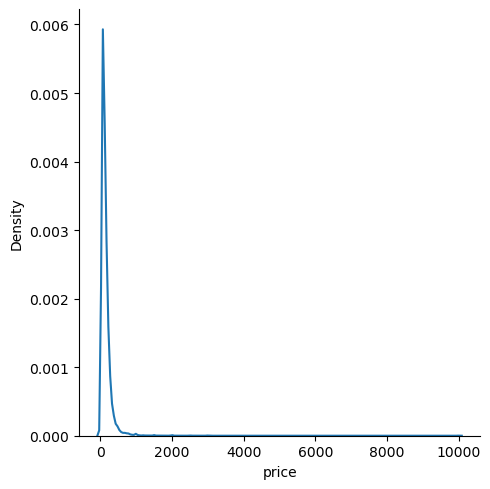

In [8]:
# распределние таргета (цены)
sns.displot(data=data, x='price', kind='kde')
plt.show()

In [9]:
# Наблюдаем что имеются выбросы, которые стоит удалить. Проверим квантиль 99%
np.quantile(data.price, 0.99)

799.0

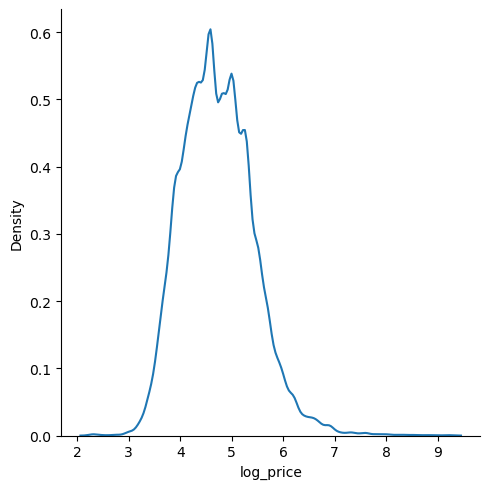

In [10]:
# Возможно целевую переменную стоит логарифмировать или преоборазовать другим способом.
np.seterr(divide = 'ignore')
data['log_price'] = np.log(data.price.replace({0: 0}))
sns.displot(data=data, x='log_price', kind='kde')
plt.show()

In [11]:
# Посмотрим на распределение переменных room_type, neighbourhood_group и neighbourhood
data.room_type.value_counts(normalize=True)

Entire home/apt    0.519665
Private room       0.456611
Shared room        0.023724
Name: room_type, dtype: float64

In [12]:
data.neighbourhood_group.value_counts(normalize=True)

Manhattan        0.443011
Brooklyn         0.411167
Queens           0.115881
Bronx            0.022313
Staten Island    0.007629
Name: neighbourhood_group, dtype: float64

In [13]:
# Посмотрим на уникальные параметры категориальных признаков
categ_feature = ['room_type', 'neighbourhood_group', 'neighbourhood']
for feature in categ_feature:
    categ_unique = data[feature].unique()
    print(f'{feature} ({len(categ_unique)})\n', data[feature].unique())

room_type (3)
 ['Private room' 'Entire home/apt' 'Shared room']
neighbourhood_group (5)
 ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
neighbourhood (221)
 ['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkin

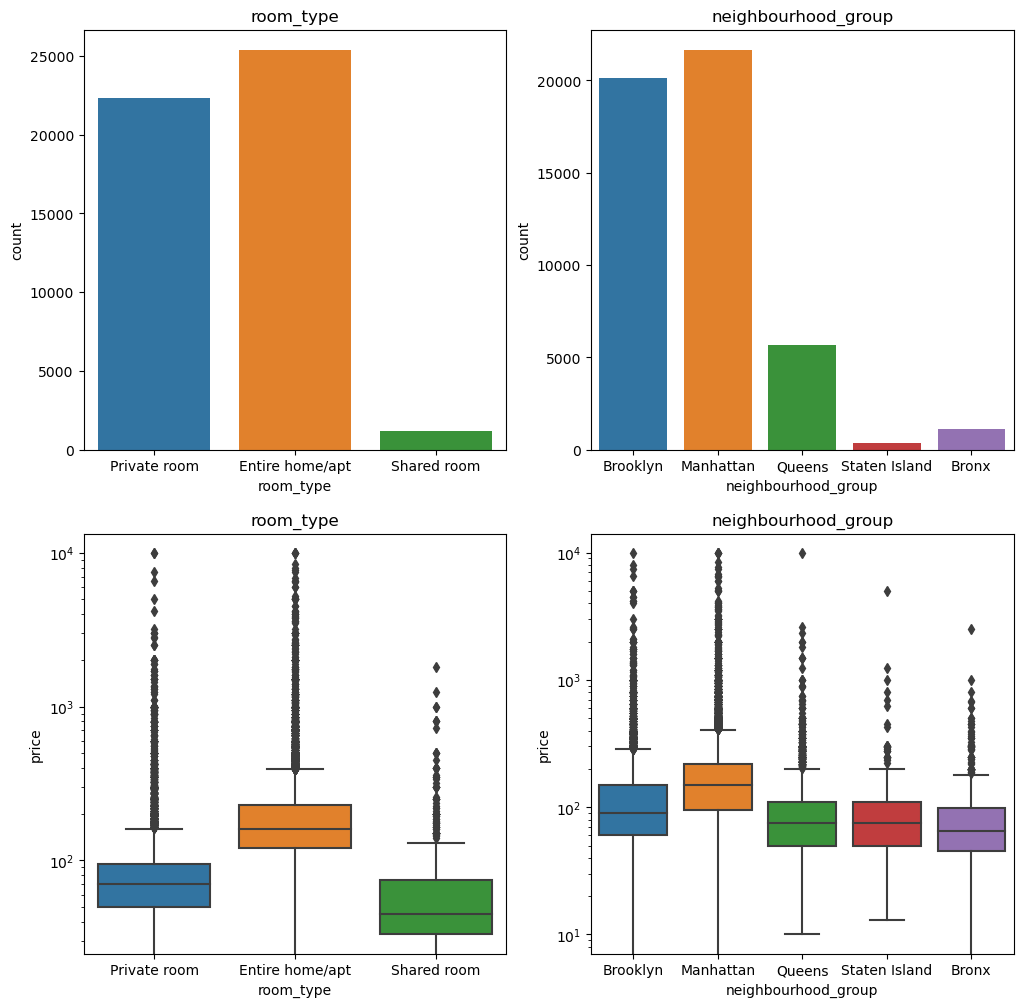

In [14]:
cats = ('room_type', 'neighbourhood_group')
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
for i, cat in enumerate(cats):
    # countplot
    ax[0,i].set_title(cat)
    sns.countplot(data=data, x=cat, ax=ax[0,i])
    # boxplot
    ax[1,i].set_title(cat)
    sns.boxplot(data=data, x=cat, y='price', ax=ax[1,i])
    ax[1,i].set_yscale('log')
plt.show()

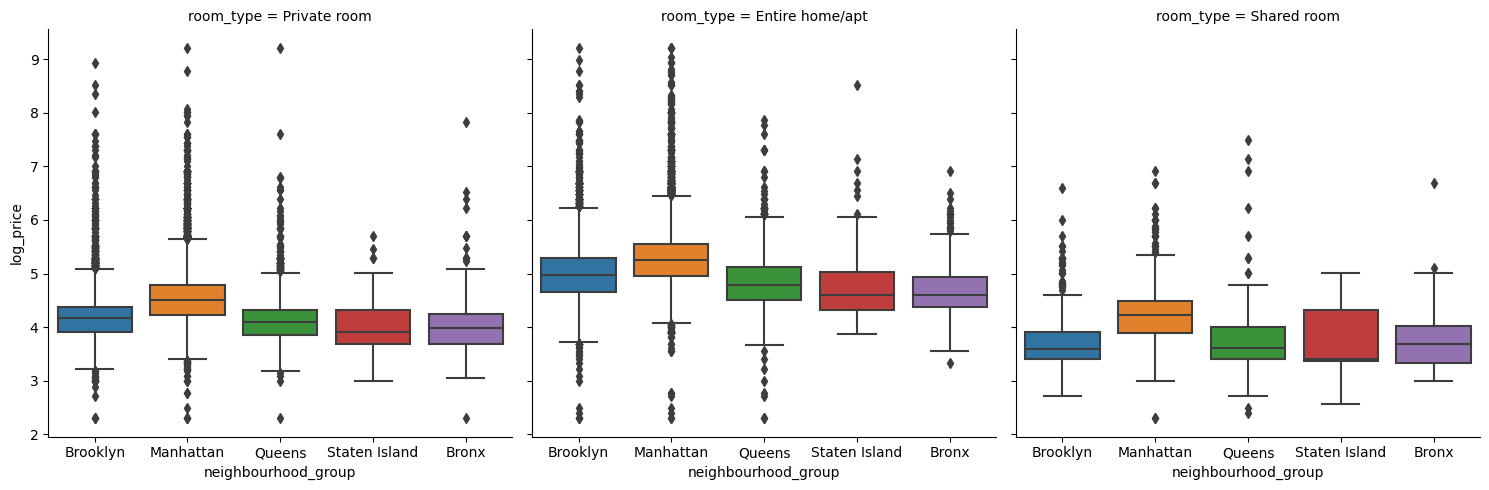

In [15]:
sns.catplot(kind='box', data=data, x='neighbourhood_group', y='log_price', col='room_type')
plt.show()

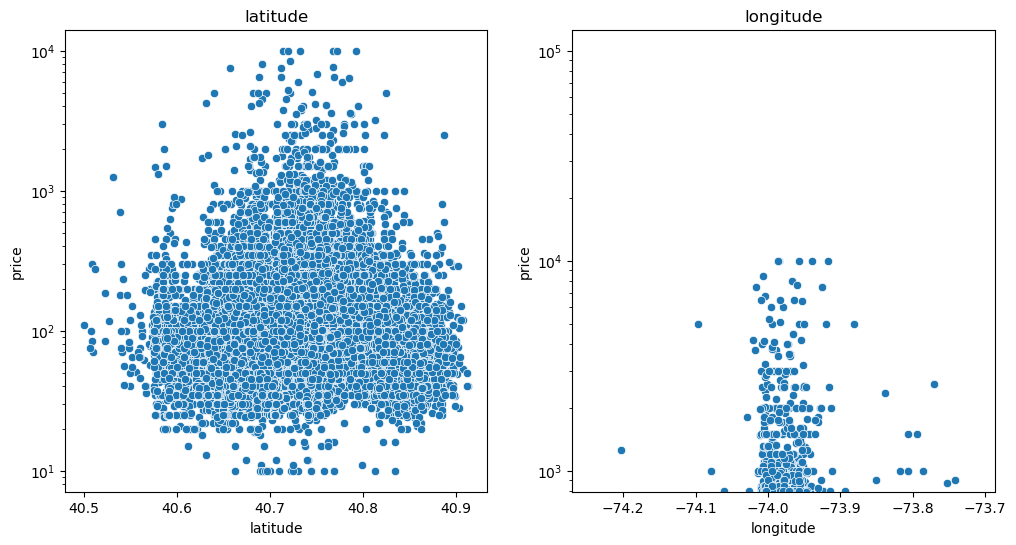

In [16]:
# посмотрим на распределение долготы и широты
cols = ('latitude', 'longitude')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 6)
for i, col in enumerate(cols):
    ax[i].set_title(col)
    sns.scatterplot(data=data, x=col, y='price', ax=ax[i])
    ax[i].set_yscale('log')
plt.show()

In [17]:
# Введем новую переменную "Расстояние до Манхеттена"
mh_coord = np.array([40.7831, -73.9712])
data['dist_to_mh'] = np.sqrt((data.latitude-mh_coord[0])**2 + (data.longitude-mh_coord[1])**2)

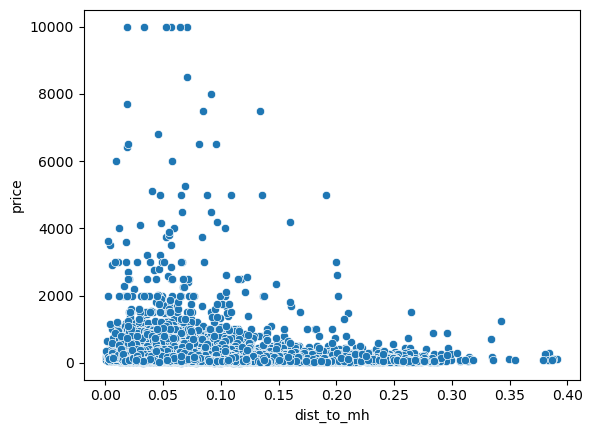

In [18]:
sns.scatterplot(data=data, x='dist_to_mh', y='price')
plt.show()

In [19]:
data.columns.tolist()

['neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'log_price',
 'dist_to_mh']

In [20]:
col_order = ['price',
             'log_price',
             'room_type',
             'latitude',
             'longitude',
             'dist_to_mh',
             'neighbourhood_group',
             'neighbourhood',             
             'minimum_nights',
             'number_of_reviews',
             'reviews_per_month', 
             'calculated_host_listings_count',
             'availability_365']
data = data[col_order]

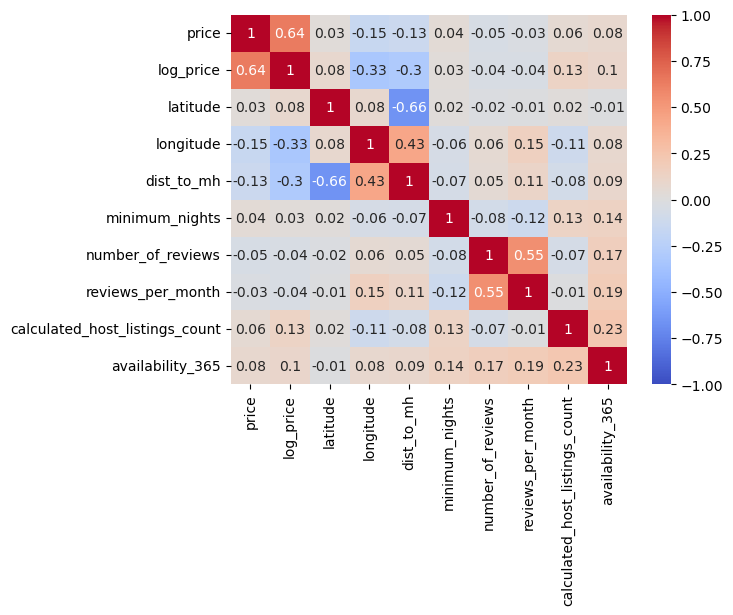

In [21]:
cor_tab = data.corr(numeric_only=True).apply(np.round, decimals=2)
# Palette
pal = sns.color_palette("coolwarm", 10000)
sns.heatmap(data=cor_tab, annot=True, cmap=pal, vmin=-1, center=0, vmax=1)
plt.show()

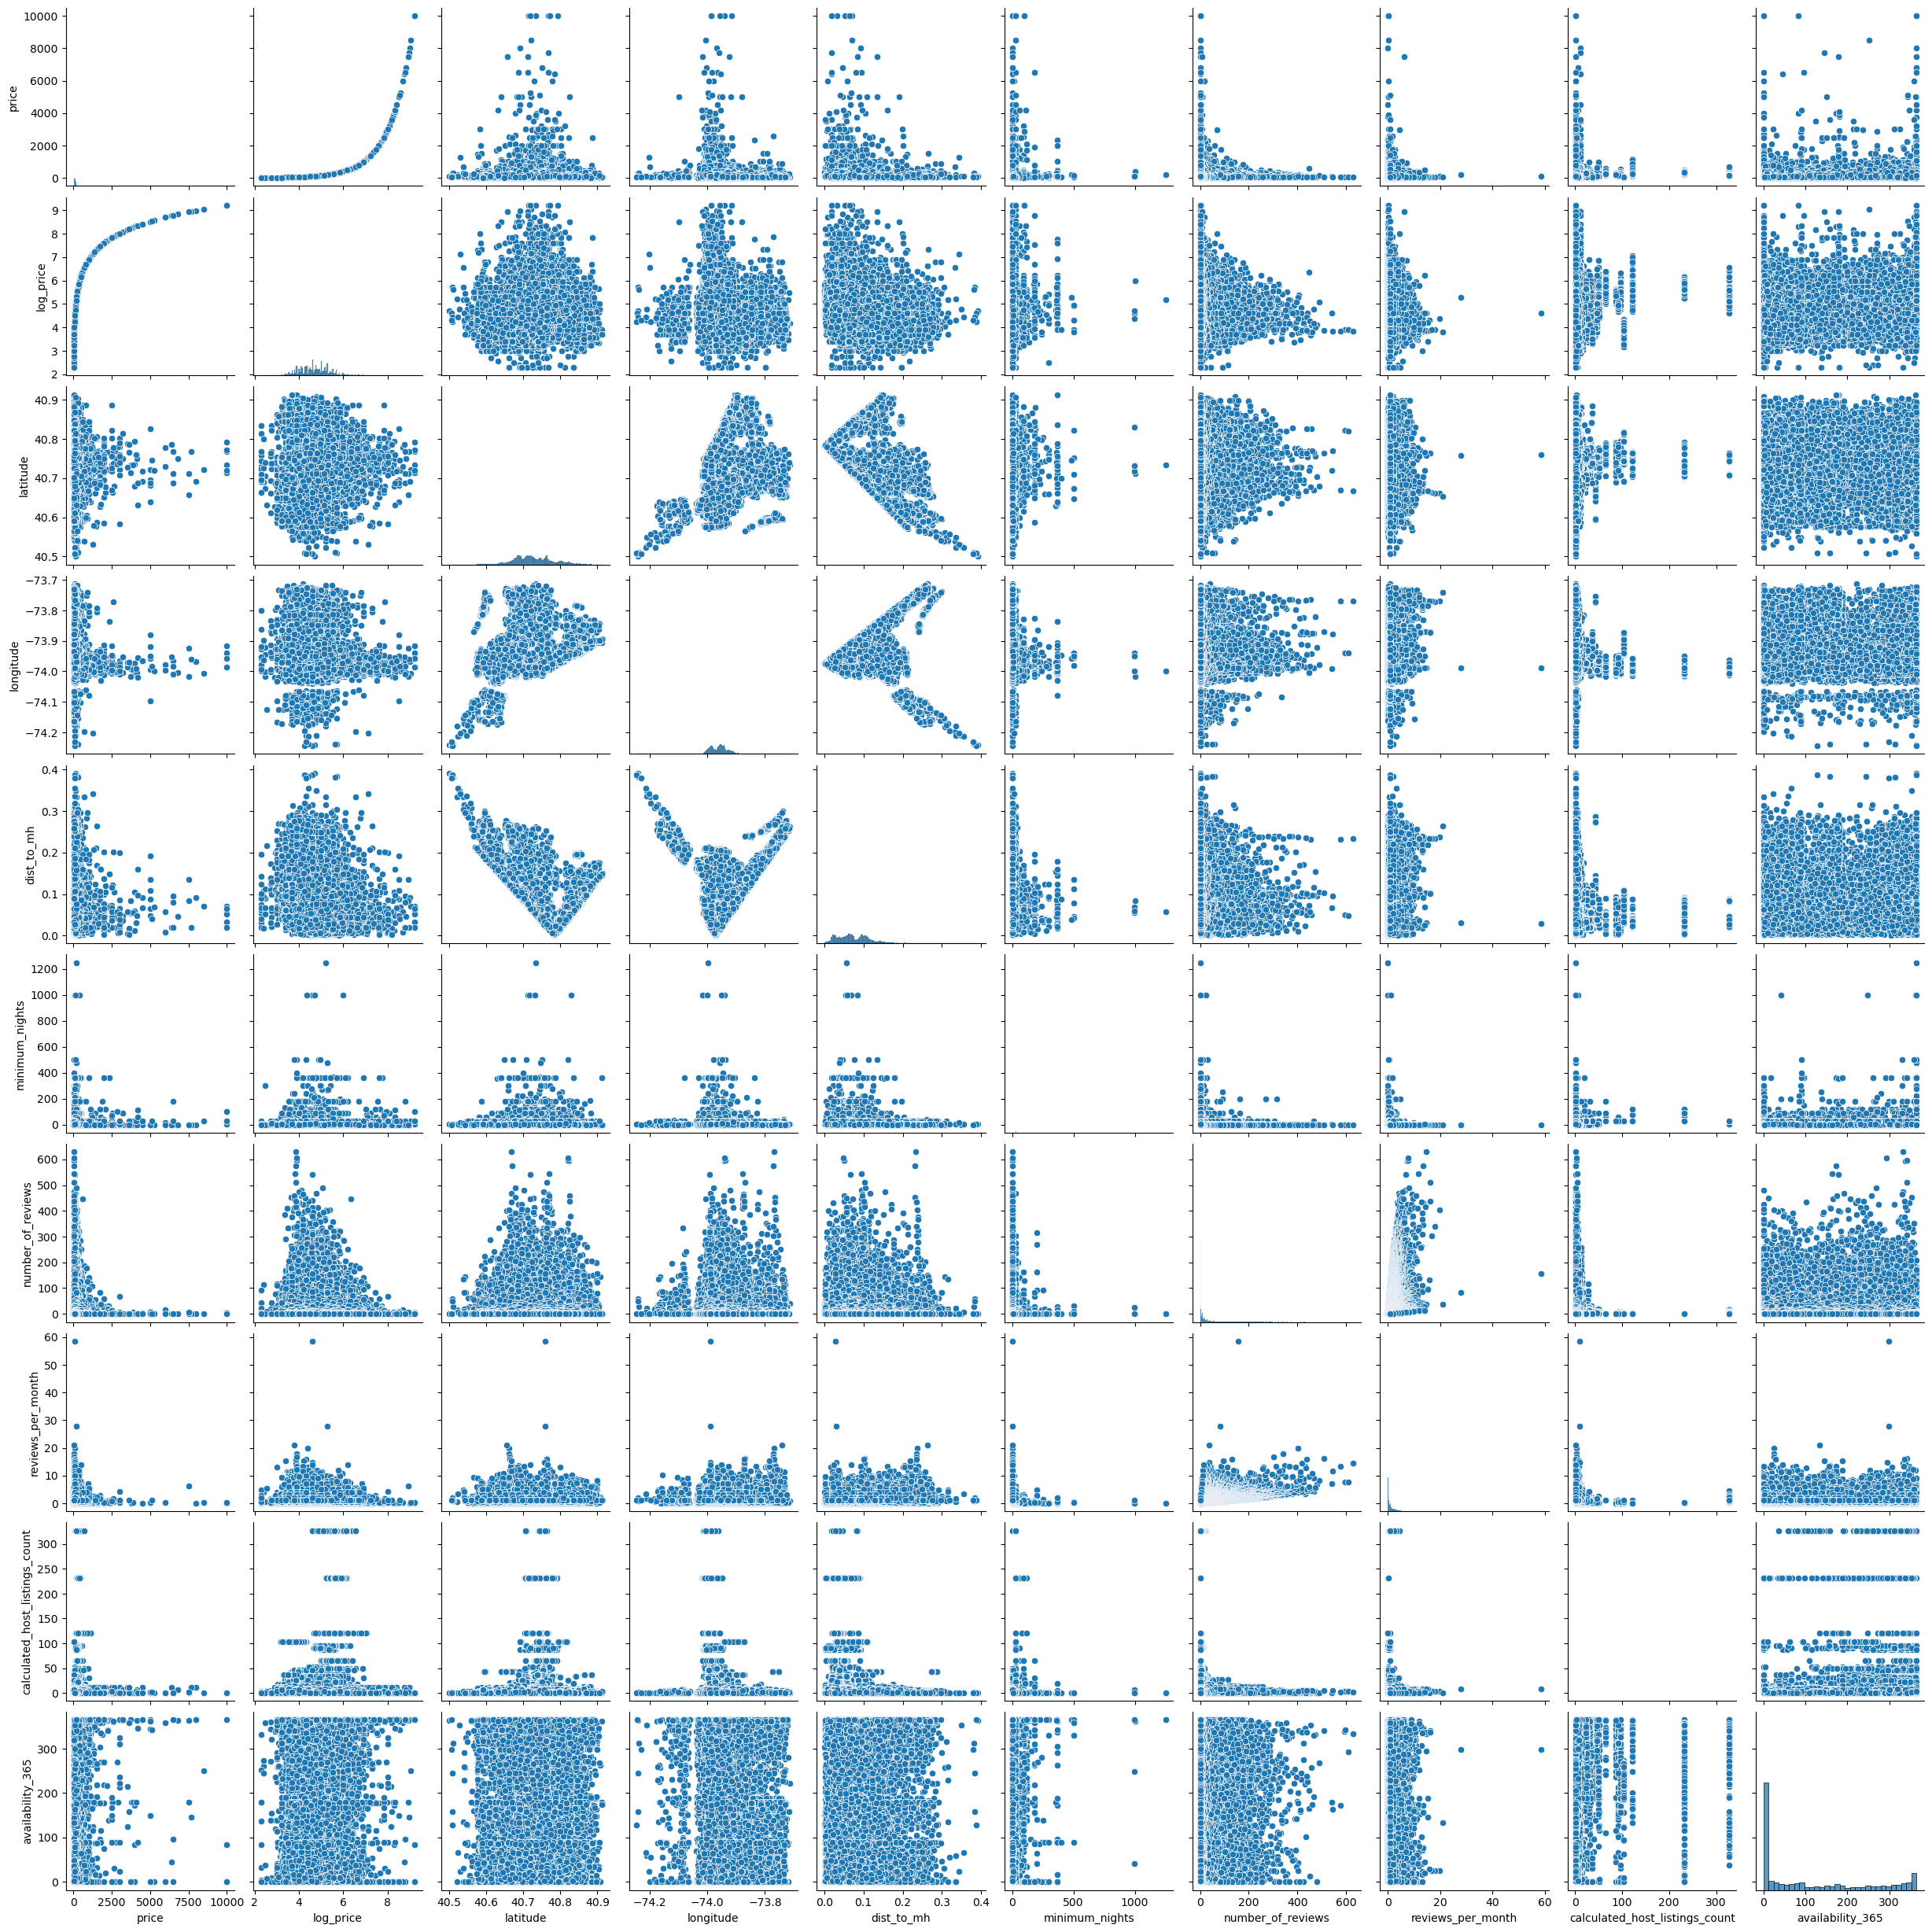

In [22]:
sns.pairplot(data)
plt.show()

Мы ранее выяснили, что данные reviews_per_month отсутствуют для записей с 0 number_of_reviews. 
Заменим отсутсвующие данные на специальное значение -1

In [23]:
data.reviews_per_month.fillna(-1, inplace=True)
data.reviews_per_month.isna().sum()

0

In [24]:
# Returns dictionary object from two lists
def create_dict(keys, values):
    return dict(zip(keys, values))


обработка категориальных переменных:
- neighbourhood_group - dummy
- neighbourhood - ordinal by median
- room_type - ordinal by median


In [25]:
pr_data = data.copy(deep=True)
pr_data = pd.get_dummies(pr_data, columns=['neighbourhood_group'])
# neighbourhood
nh_list = pr_data.groupby('neighbourhood')['price'].agg(np.median).sort_values().index.tolist()
nh_mapping = create_dict(nh_list, list(range(len(nh_list))))
pr_data['neighbourhood'] = pr_data.neighbourhood.map(nh_mapping)
# room_type
rt_ord = {'Shared room': 1, 
          'Private room': 2, 
          'Entire home/apt': 3}
pr_data['room_type'] = pr_data.room_type.map(rt_ord)
pr_data.head()

,price,log_price,room_type,latitude,longitude,dist_to_mh,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,149,5.003946,2,40.64749,-73.97237,0.135615,72,1,9,0.21,6,365,0,1,0,0,0
1,225,5.416100,3,40.75362,-73.98377,0.032048,213,1,45,0.38,2,355,0,0,1,0,0
2,150,5.010635,2,40.80902,-73.94190,0.039120,134,3,0,-1.00,1,365,0,0,1,0,0
3,89,4.488636,3,40.68514,-73.95976,0.098626,165,1,270,4.64,1,194,0,1,0,0,0
4,80,4.382027,3,40.79851,-73.94399,0.031271,145,10,9,0.10,1,0,0,0,1,0,0


Ранее было вяснено что 99% данных целевой переменной попадают в интервал между 0 и 800. 
Тогда мы можем удалить 1 % ненужных данных

In [26]:
print(np.quantile(pr_data.price, 0.99))
pr_data = pr_data[pr_data.price <= 800]

799.0


Для работы с фичами используем:

- Normalization (MinMaxScaler)
- Standardization (StandardScaler)
- Robust to outliers (RobustScaler)
- Target variable transformations:

Для преобразования целевой переменной используем:

- Raw (без преобразований)
- Log
- Sqrt

Дополнительно рассмотрим:

- PolynomialFeatures чтобы поймать нелинейные зависимости

In [27]:
# Разобъем выборку на train и test
X_train, X_test, y_train, y_test = train_test_split(pr_data.drop(['price', 'log_price'], axis=1),
                                                    pr_data['price'],
                                                    test_size=0.3, 
                                                    random_state=666)

# Разобъем выборку train2 и validation
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.3, 
                                                    random_state=666)

Моделирование:

In [28]:
# Features
# Normalization
n_scaler = MinMaxScaler()
nX_train = n_scaler.fit_transform(X_train2)
nX_test = n_scaler.transform(X_val)
# Standartization
s_scaler = StandardScaler()
sX_train = s_scaler.fit_transform(X_train2)
sX_test = s_scaler.transform(X_val)
# Robust to outliers
r_scaler = RobustScaler()
rX_train = r_scaler.fit_transform(X_train2)
rX_test = r_scaler.transform(X_val)

# Target
# Log target
log_y_train = np.log(y_train2.replace({0: 1}))
# Sqrt target
sqrt_y_train = np.sqrt(y_train2)

In [29]:
# Scaling labels
scl_lab = ['normalized', 'standardized', 'robust']
# Create dictionaries of features to try
Xtrain = create_dict(scl_lab, [nX_train, sX_train, rX_train])
Xtest = create_dict(scl_lab, [nX_test, sX_test, rX_test])
# Target trasformation labels
transf_lab = ['raw', 'log', 'sqrt']
# Create dictionaries of targets
Ytrain = create_dict(transf_lab, [y_train2, log_y_train, sqrt_y_train])
# Target back transformations
t_trans = create_dict(transf_lab, [lambda x: x, np.exp, lambda x: x**2])

Обучение:

In [30]:
# Linear regressions to train
lr_models = [RidgeCV(), LassoCV(),ElasticNetCV()]
# DataFrame to save results
res_cols = ['model', 'features', 'target']

In [31]:
from sklearn.base import clone
def train_rate(models,
               X_train, y_train, 
               X_test, y_test, 
               func=lambda x: x, 
               random_state=666):
    result = list()    
    for model in models:
        res = dict()
        np.random.seed(random_state)
        mdl = clone(model)
        reg = mdl.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        res['model'] = reg
        res['MAE'] = mean_absolute_error(y_test, func(y_pred))
        res['RMSE'] = mean_squared_error(y_test, func(y_pred), squared=False)
        res['R2'] = r2_score(y_test, func(y_pred))
        result.append(res)
    return result

In [32]:
results = pd.DataFrame(columns=res_cols)
# Feature loop
for key in Xtrain.keys():
    sc_part = pd.DataFrame(columns=res_cols)
    # Target transformation loop
    for tkey in Ytrain.keys():
        t_part = pd.DataFrame(columns=res_cols)
        # Linear regressions
        lr_part = train_rate(lr_models, 
                             Xtrain[key], Ytrain[tkey], 
                             Xtest[key], y_val, 
                             t_trans[tkey])
        t_part = pd.concat([t_part, pd.DataFrame(lr_part)], axis=0)
        t_part['target'] = tkey
        # Mark target transformation
        sc_part = pd.concat([sc_part, t_part], axis=0)
    sc_part['features'] = key
    #display(sc_part)
    results = pd.concat([results, sc_part])

In [33]:
results.sort_values(['RMSE','MAE', 'R2'])

,model,features,target,MAE,RMSE,R2
0,RidgeCV(),standardized,sqrt,49.697215,84.641189,0.366147
0,RidgeCV(),robust,sqrt,49.696763,84.646491,0.366067
1,LassoCV(),standardized,sqrt,49.690902,84.667694,0.365750
2,ElasticNetCV(),standardized,sqrt,49.686357,84.677603,0.365601
0,RidgeCV(),normalized,sqrt,49.719365,84.691677,0.365390
1,LassoCV(),normalized,sqrt,49.716280,84.719670,0.364971
1,LassoCV(),robust,sqrt,49.722250,84.918994,0.361979
0,RidgeCV(),standardized,raw,53.644391,84.951035,0.361498
0,RidgeCV(),robust,raw,53.641588,84.951620,0.361489
1,LassoCV(),standardized,raw,53.633145,84.953216,0.361465


In [34]:
sum_ftr = results.groupby('features').mean(numeric_only=True).sort_values(['RMSE','MAE', 'R2'])
sum_target = results.groupby('target').mean(numeric_only=True).sort_values(['RMSE','MAE', 'R2'])
summary = results.groupby(['features', 'target']).mean(numeric_only=True)
display(sum_ftr, sum_target, summary)

,MAE,RMSE,R2
features,,,
standardized,50.504127,85.095335,0.359312
normalized,50.566073,85.298456,0.356243
robust,51.156536,86.023616,0.344905


,MAE,RMSE,R2
target,,,
sqrt,49.724091,84.812529,0.363574
log,48.269790,85.761770,0.349250
raw,54.232855,85.843109,0.347636


MAE       RMSE        R2
features     target                                
normalized   log     48.305330  85.756904  0.349326
             raw     53.633324  85.322143  0.355885
             sqrt    49.759564  84.816321  0.363519
robust       log     48.256954  85.879595  0.347460
             raw     55.491438  87.232151  0.325885
             sqrt    49.721218  84.959102  0.361370
standardized log     48.247087  85.648811  0.350965
             raw     53.573803  84.975032  0.361137
             sqrt    49.691491  84.662162  0.365833

Итог:

Ощутимой разницы между преобразовании фичей нет. Логарифмическое преобразование и SQRT() преобразования целевой переменной дает лучшие результаты, чем необработанные данные.

Итого для финального обучения и теста будем использовать следующее:

- Стандартизация и SQRT()
- Стандартизация и логарифмическое преобразование 
- Полином второй степени стандартизированных фич и все 3 вида фичей

Этап 2

Подготовка

In [35]:
# Features
# Standartization
s_scaler = StandardScaler()
sX_train = s_scaler.fit_transform(X_train)
sX_test = s_scaler.transform(X_test)
# Polynomial
p2 = PolynomialFeatures(degree=2)
p2X_train = p2.fit_transform(sX_train)
p2X_test = p2.transform(sX_test)

# Target
# Log target
log_y_train = np.log(y_train.replace({0: 1}))
# Sqrt target
sqrt_y_train = np.sqrt(y_train)

In [36]:
ftr_target_labels = ['standardized_sqrt', 'standardized_log', 'polynomial_raw', 'polynomial_sqrt', 'polynomial_log']
ftr_target = zip(ftr_target_labels, 
                 [sX_train, sX_train, p2X_train, p2X_train, p2X_train],
                 [sX_test, sX_test, p2X_test, p2X_test, p2X_test],
                 [sqrt_y_train, log_y_train, y_train, sqrt_y_train, log_y_train],
                 [lambda x: x**2, np.exp, lambda x: x,lambda x: x**2, np.exp ])

lr_models = [RidgeCV(alphas = [0.1, 0.5, 1, 3, 6, 8, 10]), 
             LassoCV(), 
             ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5 , 0.7, 0.9, 0.95, 0.99])]
lr_model_desc = ['Ridge', 'Lasso', 'ElasticNet']
res_cols = ['model', 'features_target', 'MAE', 'RMSE', 'R2']
results = pd.DataFrame(columns=res_cols)
for lab, train_X, test_X, train_y, func in ftr_target:
    sc_part = pd.DataFrame(columns=res_cols)
    lr_dict = train_rate(lr_models, 
                         train_X, train_y, 
                         test_X, y_test, func)
    sc_part = pd.concat([sc_part, pd.DataFrame(lr_dict)])
    sc_part['model_str'] = lr_model_desc
    sc_part['features_target'] = lab
    #display(sc_part)
    results = pd.concat([results, sc_part], axis=0)

In [37]:
results

,model,features_target,MAE,RMSE,R2,model_str
0,"RidgeCV(alphas=[0.1, 0.5, 1, 3, 6, 8, 10])",standardized_sqrt,48.099781,82.874993,0.381662,Ridge
1,LassoCV(),standardized_sqrt,48.098806,82.889550,0.381444,Lasso
2,"ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9...",standardized_sqrt,48.098771,82.889682,0.381442,ElasticNet
0,"RidgeCV(alphas=[0.1, 0.5, 1, 3, 6, 8, 10])",standardized_log,46.457519,83.523419,0.371948,Ridge
1,LassoCV(),standardized_log,46.454958,83.549922,0.371549,Lasso
2,"ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9...",standardized_log,46.454956,83.549965,0.371548,ElasticNet
0,"RidgeCV(alphas=[0.1, 0.5, 1, 3, 6, 8, 10])",polynomial_raw,48.682969,80.498620,0.416614,Ridge
1,LassoCV(),polynomial_raw,48.514307,80.401306,0.418024,Lasso
2,"ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9...",polynomial_raw,48.504986,80.398330,0.418067,ElasticNet
0,"RidgeCV(alphas=[0.1, 0.5, 1, 3, 6, 8, 10])",polynomial_sqrt,46.149751,80.437371,0.417501,Ridge


На логарифмируемом таргете полином выдает неадекватные метрики, выбросим не будем рассматривать это в сравнении

In [38]:
results = results[results.features_target != 'polynomial_log']

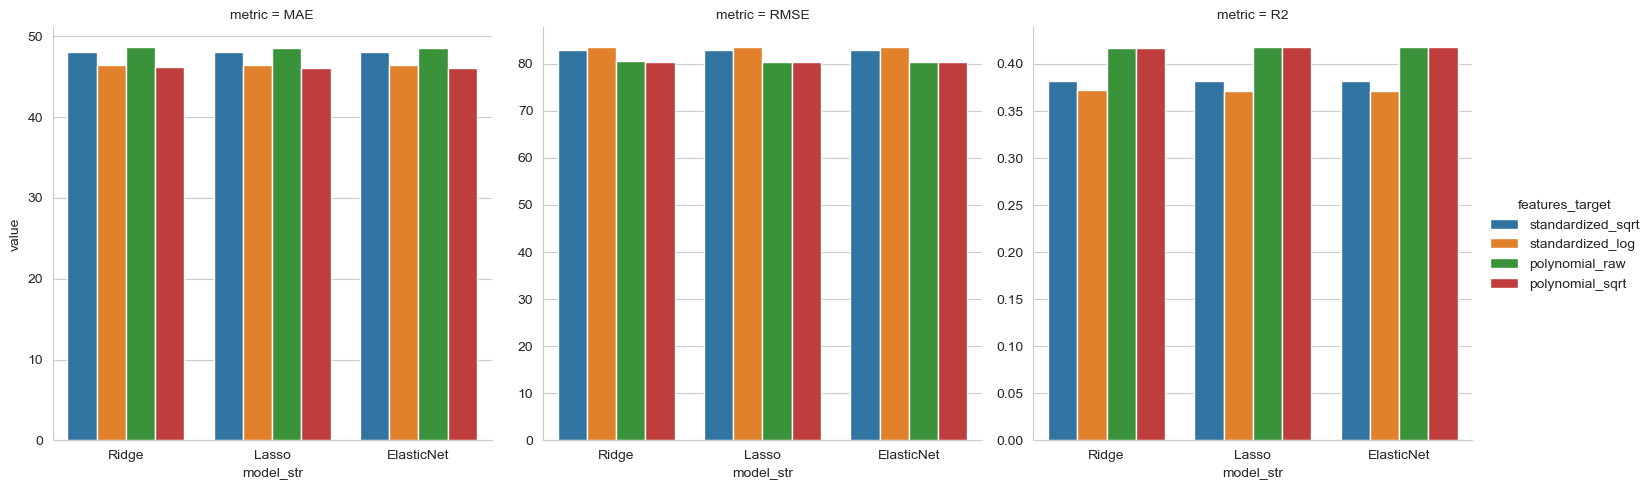

In [39]:
res_long = results.drop('model', axis=1).melt(id_vars=['features_target', 'model_str'], var_name='metric')

sns.set_style("whitegrid")
sns.catplot(data=res_long, kind='bar', x='model_str', y='value', hue='features_target', col='metric', sharey=False)
plt.show()

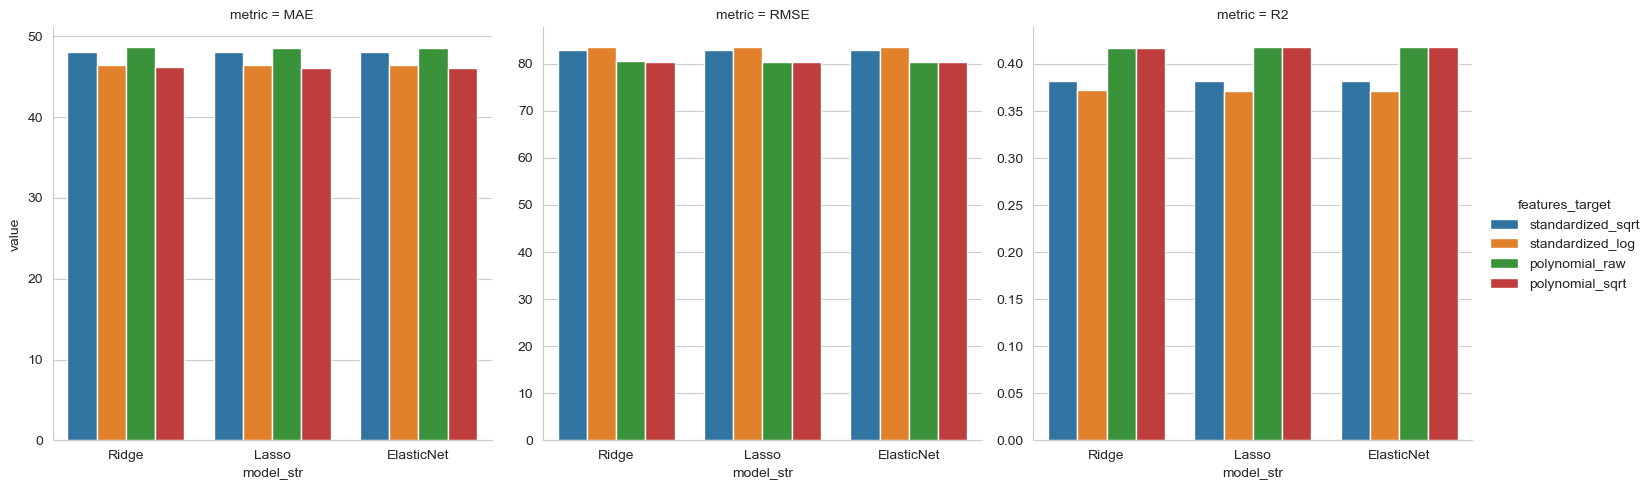

In [40]:
res_long = results.drop('model', axis=1).melt(id_vars=['features_target', 'model_str'], var_name='metric')

sns.set_style("whitegrid")
sns.catplot(data=res_long, kind='bar', x='model_str', y='value', hue='features_target', col='metric', sharey=False)
plt.show()

Выбор алгоритма практически не влияет на качество модели. Наибольшую значимость имеют трансформации и выбросы целевой переменной. Данные скорее всего имеют нелинейную зависимость, поэтому некоторые из метрик(RMSE, R2) лучше, когда генерируем полином из фичей.

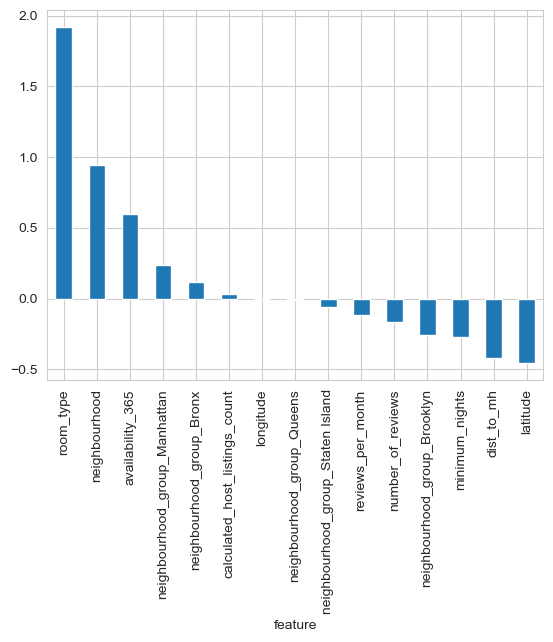

In [41]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": results['model'].iloc[0].coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar();
plt.show()

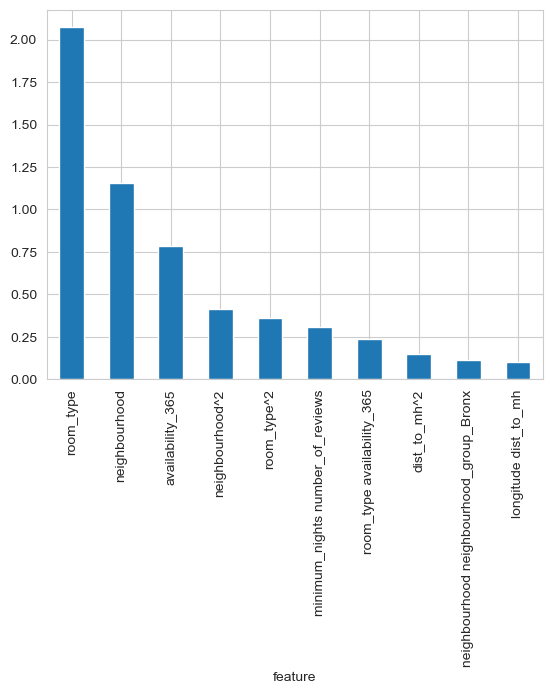

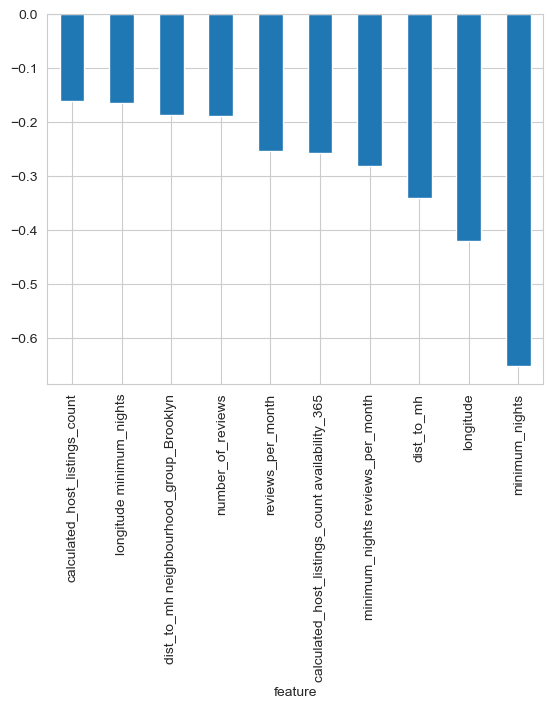

In [42]:
pol_names = p2.get_feature_names_out(X_train.columns)
featureImportance = pd.DataFrame({"feature": pol_names, 
                                  "importance": results['model'].iloc[-1].coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].iloc[:10].plot.bar();
plt.show()
featureImportance["importance"].iloc[-10:].plot.bar();
plt.show()